In [ ]:
pip install torch-lucent

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.6 MB/s eta 0:00:00
 

In [ ]:
from __future__ import absolute_import, division, print_function

import torch
import torch.nn as nn
import torch.nn.functional as F


class AdditionLayer(nn.Module):
    def forward(self, t_1, t_2):
        return t_1 + t_2


class MaxPool2dLayer(nn.Module):
    def forward(self, tensor, kernel_size=(3, 3), stride=(1, 1),
                padding=0, ceil_mode=False):
        return F.max_pool2d(tensor, kernel_size, stride=stride,
                            padding=padding, ceil_mode=ceil_mode)


class PadLayer(nn.Module):
    def forward(self, tensor, padding=(1, 1, 1, 1), value=None):
        if value is None:
            return F.pad(tensor, padding)
        return F.pad(tensor, padding, value=value)


class ReluLayer(nn.Module):
    def forward(self, tensor):
        return F.relu(tensor)


class RedirectedReLU(torch.autograd.Function):
    """
    A workaround when there is no gradient flow from an initial random input
    See https://github.com/tensorflow/lucid/blob/master/lucid/misc/redirected_relu_grad.py
    Note: this means that the gradient is technically "wrong"
    TODO: the original Lucid library has a more sophisticated way of doing this
    """
    @staticmethod
    def forward(ctx, input_tensor):
        ctx.save_for_backward(input_tensor)
        return input_tensor.clamp(min=0)
    @staticmethod
    def backward(ctx, grad_output):
        input_tensor, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input_tensor < 0] = grad_input[input_tensor < 0] * 1e-1
        return grad_input


class RedirectedReluLayer(nn.Module):
    def forward(self, tensor):
        return RedirectedReLU.apply(tensor)


class SoftMaxLayer(nn.Module):
    def forward(self, tensor, dim=1):
        return F.softmax(tensor, dim=dim)


class DropoutLayer(nn.Module):
    def forward(self, tensor, p=0.4000000059604645, training=False, inplace=True):
        return F.dropout(input=tensor, p=p, training=training, inplace=inplace)


class CatLayer(nn.Module):
    def forward(self, tensor_list, dim=1):
        return torch.cat(tensor_list, dim)


class LocalResponseNormLayer(nn.Module):
    def forward(self, tensor, size=5, alpha=9.999999747378752e-05, beta=0.75, k=1.0):
        return F.local_response_norm(tensor, size=size, alpha=alpha, beta=beta, k=k)


class AVGPoolLayer(nn.Module):
    def forward(self, tensor, kernel_size=(7, 7), stride=(1, 1), padding=(0,),
                ceil_mode=False, count_include_pad=False):
        return F.avg_pool2d(tensor, kernel_size=kernel_size, stride=stride,
                            padding=padding, ceil_mode=ceil_mode,
                            count_include_pad=count_include_pad)


In [ ]:
from __future__ import absolute_import, division, print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
from lucent.modelzoo.inceptionv1 import helper_layers


model_urls = {
    # InceptionV1 model used in Lucid examples, converted by ProGamerGov
    'inceptionv1': 'https://github.com/ProGamerGov/pytorch-old-tensorflow-models/raw/master/inception5h.pth',
}


class InceptionV1(nn.Module):

    def __init__(self, pretrained=False, progress=True, redirected_ReLU=True):
        super(InceptionV1, self).__init__()
        self.conv2d0_pre_relu_conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7, 7), stride=(2, 2), groups=1, bias=True)
        self.conv2d1_pre_relu_conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.conv2d2_pre_relu_conv = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.mixed3a_1x1_pre_relu_conv = nn.Conv2d(in_channels=192, out_channels=64, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed3a_3x3_bottleneck_pre_relu_conv = nn.Conv2d(in_channels=192, out_channels=96, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed3a_5x5_bottleneck_pre_relu_conv = nn.Conv2d(in_channels=192, out_channels=16, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed3a_pool_reduce_pre_relu_conv = nn.Conv2d(in_channels=192, out_channels=32, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed3a_3x3_pre_relu_conv = nn.Conv2d(in_channels=96, out_channels=128, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.mixed3a_5x5_pre_relu_conv = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), stride=(1, 1), groups=1, bias=True)
        self.mixed3b_1x1_pre_relu_conv = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed3b_3x3_bottleneck_pre_relu_conv = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed3b_5x5_bottleneck_pre_relu_conv = nn.Conv2d(in_channels=256, out_channels=32, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed3b_pool_reduce_pre_relu_conv = nn.Conv2d(in_channels=256, out_channels=64, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed3b_3x3_pre_relu_conv = nn.Conv2d(in_channels=128, out_channels=192, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.mixed3b_5x5_pre_relu_conv = nn.Conv2d(in_channels=32, out_channels=96, kernel_size=(5, 5), stride=(1, 1), groups=1, bias=True)
        self.mixed4a_1x1_pre_relu_conv = nn.Conv2d(in_channels=480, out_channels=192, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed4a_3x3_bottleneck_pre_relu_conv = nn.Conv2d(in_channels=480, out_channels=96, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed4a_5x5_bottleneck_pre_relu_conv = nn.Conv2d(in_channels=480, out_channels=16, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed4a_pool_reduce_pre_relu_conv = nn.Conv2d(in_channels=480, out_channels=64, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed4a_3x3_pre_relu_conv = nn.Conv2d(in_channels=96, out_channels=204, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.mixed4a_5x5_pre_relu_conv = nn.Conv2d(in_channels=16, out_channels=48, kernel_size=(5, 5), stride=(1, 1), groups=1, bias=True)
        self.mixed4b_1x1_pre_relu_conv = nn.Conv2d(in_channels=508, out_channels=160, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed4b_3x3_bottleneck_pre_relu_conv = nn.Conv2d(in_channels=508, out_channels=112, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed4b_5x5_bottleneck_pre_relu_conv = nn.Conv2d(in_channels=508, out_channels=24, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed4b_pool_reduce_pre_relu_conv = nn.Conv2d(in_channels=508, out_channels=64, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed4b_3x3_pre_relu_conv = nn.Conv2d(in_channels=112, out_channels=224, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.mixed4b_5x5_pre_relu_conv = nn.Conv2d(in_channels=24, out_channels=64, kernel_size=(5, 5), stride=(1, 1), groups=1, bias=True)
        self.mixed4c_1x1_pre_relu_conv = nn.Conv2d(in_channels=512, out_channels=128, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed4c_3x3_bottleneck_pre_relu_conv = nn.Conv2d(in_channels=512, out_channels=128, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed4c_5x5_bottleneck_pre_relu_conv = nn.Conv2d(in_channels=512, out_channels=24, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed4c_pool_reduce_pre_relu_conv = nn.Conv2d(in_channels=512, out_channels=64, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed4c_3x3_pre_relu_conv = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.mixed4c_5x5_pre_relu_conv = nn.Conv2d(in_channels=24, out_channels=64, kernel_size=(5, 5), stride=(1, 1), groups=1, bias=True)
        self.mixed4d_1x1_pre_relu_conv = nn.Conv2d(in_channels=512, out_channels=112, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed4d_3x3_bottleneck_pre_relu_conv = nn.Conv2d(in_channels=512, out_channels=144, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed4d_5x5_bottleneck_pre_relu_conv = nn.Conv2d(in_channels=512, out_channels=32, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed4d_pool_reduce_pre_relu_conv = nn.Conv2d(in_channels=512, out_channels=64, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed4d_3x3_pre_relu_conv = nn.Conv2d(in_channels=144, out_channels=288, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.mixed4d_5x5_pre_relu_conv = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), stride=(1, 1), groups=1, bias=True)
        self.mixed4e_1x1_pre_relu_conv = nn.Conv2d(in_channels=528, out_channels=256, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed4e_3x3_bottleneck_pre_relu_conv = nn.Conv2d(in_channels=528, out_channels=160, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed4e_5x5_bottleneck_pre_relu_conv = nn.Conv2d(in_channels=528, out_channels=32, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed4e_pool_reduce_pre_relu_conv = nn.Conv2d(in_channels=528, out_channels=128, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed4e_3x3_pre_relu_conv = nn.Conv2d(in_channels=160, out_channels=320, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.mixed4e_5x5_pre_relu_conv = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=(5, 5), stride=(1, 1), groups=1, bias=True)
        self.mixed5a_1x1_pre_relu_conv = nn.Conv2d(in_channels=832, out_channels=256, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed5a_3x3_bottleneck_pre_relu_conv = nn.Conv2d(in_channels=832, out_channels=160, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed5a_5x5_bottleneck_pre_relu_conv = nn.Conv2d(in_channels=832, out_channels=48, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed5a_pool_reduce_pre_relu_conv = nn.Conv2d(in_channels=832, out_channels=128, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed5a_3x3_pre_relu_conv = nn.Conv2d(in_channels=160, out_channels=320, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.mixed5a_5x5_pre_relu_conv = nn.Conv2d(in_channels=48, out_channels=128, kernel_size=(5, 5), stride=(1, 1), groups=1, bias=True)
        self.mixed5b_1x1_pre_relu_conv = nn.Conv2d(in_channels=832, out_channels=384, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed5b_3x3_bottleneck_pre_relu_conv = nn.Conv2d(in_channels=832, out_channels=192, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed5b_5x5_bottleneck_pre_relu_conv = nn.Conv2d(in_channels=832, out_channels=48, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed5b_pool_reduce_pre_relu_conv = nn.Conv2d(in_channels=832, out_channels=128, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
        self.mixed5b_3x3_pre_relu_conv = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.mixed5b_5x5_pre_relu_conv = nn.Conv2d(in_channels=48, out_channels=128, kernel_size=(5, 5), stride=(1, 1), groups=1, bias=True)
        self.softmax2_pre_activation_matmul = nn.Linear(in_features=1024, out_features=1008, bias=True)

        self.add_layers(redirected_ReLU)

        if pretrained:
            self.load_state_dict(torch.hub.load_state_dict_from_url(model_urls['inceptionv1'], progress=progress))

    def add_layers(self, redirected_ReLU=True):
        if redirected_ReLU:
            relu = helper_layers.RedirectedReluLayer
        else:
            relu = helper_layers.ReluLayer
        self.conv2d0 = relu()
        self.maxpool0 = helper_layers.MaxPool2dLayer()
        self.conv2d1 = relu()
        self.conv2d2 = relu()
        self.maxpool1 = helper_layers.MaxPool2dLayer()
        self.mixed3a_pool = helper_layers.MaxPool2dLayer()
        self.mixed3a_1x1 = relu()
        self.mixed3a_3x3_bottleneck = relu()
        self.mixed3a_5x5_bottleneck = relu()
        self.mixed3a_pool_reduce = relu()
        self.mixed3a_3x3 = relu()
        self.mixed3a_5x5 = relu()
        self.mixed3a = helper_layers.CatLayer()
        self.mixed3b_pool = helper_layers.MaxPool2dLayer()
        self.mixed3b_1x1 = relu()
        self.mixed3b_3x3_bottleneck = relu()
        self.mixed3b_5x5_bottleneck = relu()
        self.mixed3b_pool_reduce = relu()
        self.mixed3b_3x3 = relu()
        self.mixed3b_5x5 = relu()
        self.mixed3b = helper_layers.CatLayer()
        self.maxpool4 = helper_layers.MaxPool2dLayer()
        self.mixed4a_pool = helper_layers.MaxPool2dLayer()
        self.mixed4a_1x1 = relu()
        self.mixed4a_3x3_bottleneck = relu()
        self.mixed4a_5x5_bottleneck = relu()
        self.mixed4a_pool_reduce = relu()
        self.mixed4a_3x3 = relu()
        self.mixed4a_5x5 = relu()
        self.mixed4a = helper_layers.CatLayer()
        self.mixed4b_pool = helper_layers.MaxPool2dLayer()
        self.mixed4b_1x1 = relu()
        self.mixed4b_3x3_bottleneck = relu()
        self.mixed4b_5x5_bottleneck = relu()
        self.mixed4b_pool_reduce = relu()
        self.mixed4b_3x3 = relu()
        self.mixed4b_5x5 = relu()
        self.mixed4b = helper_layers.CatLayer()
        self.mixed4c_pool = helper_layers.MaxPool2dLayer()
        self.mixed4c_1x1 = relu()
        self.mixed4c_3x3_bottleneck = relu()
        self.mixed4c_5x5_bottleneck = relu()
        self.mixed4c_pool_reduce = relu()
        self.mixed4c_3x3 = relu()
        self.mixed4c_5x5 = relu()
        self.mixed4c = helper_layers.CatLayer()
        self.mixed4d_pool = helper_layers.MaxPool2dLayer()
        self.mixed4d_1x1 = relu()
        self.mixed4d_3x3_bottleneck = relu()
        self.mixed4d_5x5_bottleneck = relu()
        self.mixed4d_pool_reduce = relu()
        self.mixed4d_3x3 = relu()
        self.mixed4d_5x5 = relu()
        self.mixed4d = helper_layers.CatLayer()
        self.mixed4e_pool = helper_layers.MaxPool2dLayer()
        self.mixed4e_1x1 = relu()
        self.mixed4e_3x3_bottleneck = relu()
        self.mixed4e_5x5_bottleneck = relu()
        self.mixed4e_pool_reduce = relu()
        self.mixed4e_3x3 = relu()
        self.mixed4e_5x5 = relu()
        self.mixed4e = helper_layers.CatLayer()
        self.maxpool10 = helper_layers.MaxPool2dLayer()
        self.mixed5a_pool = helper_layers.MaxPool2dLayer()
        self.mixed5a_1x1 = relu()
        self.mixed5a_3x3_bottleneck = relu()
        self.mixed5a_5x5_bottleneck = relu()
        self.mixed5a_pool_reduce = relu()
        self.mixed5a_3x3 = relu()
        self.mixed5a_5x5 = relu()
        self.mixed5a = helper_layers.CatLayer()
        self.mixed5b_pool = helper_layers.MaxPool2dLayer()
        self.mixed5b_1x1 = relu()
        self.mixed5b_3x3_bottleneck = relu()
        self.mixed5b_5x5_bottleneck = relu()
        self.mixed5b_pool_reduce = relu()
        self.mixed5b_3x3 = relu()
        self.mixed5b_5x5 = relu()
        self.mixed5b = helper_layers.CatLayer()
        self.softmax2 = helper_layers.SoftMaxLayer()

    def forward(self, x):
        conv2d0_pre_relu_conv_pad = F.pad(x, (2, 3, 2, 3))
        conv2d0_pre_relu_conv = self.conv2d0_pre_relu_conv(conv2d0_pre_relu_conv_pad)
        conv2d0 = self.conv2d0(conv2d0_pre_relu_conv)
        maxpool0_pad = F.pad(conv2d0, (0, 1, 0, 1), value=float('-inf'))
        maxpool0 = self.maxpool0(maxpool0_pad, kernel_size=(3, 3), stride=(2, 2), padding=0, ceil_mode=False)
        localresponsenorm0 = F.local_response_norm(maxpool0, size=10, alpha=10 * 0.00009999999747378752, beta=0.5, k=2)
        conv2d1_pre_relu_conv = self.conv2d1_pre_relu_conv(localresponsenorm0)
        conv2d1 = self.conv2d1(conv2d1_pre_relu_conv)
        conv2d2_pre_relu_conv_pad = F.pad(conv2d1, (1, 1, 1, 1))
        conv2d2_pre_relu_conv = self.conv2d2_pre_relu_conv(conv2d2_pre_relu_conv_pad)
        conv2d2 = self.conv2d2(conv2d2_pre_relu_conv)
        localresponsenorm1 = F.local_response_norm(conv2d2, size=10, alpha=10 * 0.00009999999747378752, beta=0.5, k=2)
        maxpool1_pad = F.pad(localresponsenorm1, (0, 1, 0, 1), value=float('-inf'))
        maxpool1 = self.maxpool1(maxpool1_pad, kernel_size=(3, 3), stride=(2, 2), padding=0, ceil_mode=False)
        mixed3a_1x1_pre_relu_conv = self.mixed3a_1x1_pre_relu_conv(maxpool1)
        mixed3a_3x3_bottleneck_pre_relu_conv = self.mixed3a_3x3_bottleneck_pre_relu_conv(maxpool1)
        mixed3a_5x5_bottleneck_pre_relu_conv = self.mixed3a_5x5_bottleneck_pre_relu_conv(maxpool1)
        mixed3a_pool_pad = F.pad(maxpool1, (1, 1, 1, 1), value=float('-inf'))
        mixed3a_pool = self.mixed3a_pool(mixed3a_pool_pad, kernel_size=(3, 3), stride=(1, 1), padding=0, ceil_mode=False)
        mixed3a_1x1 = self.mixed3a_1x1(mixed3a_1x1_pre_relu_conv)
        mixed3a_3x3_bottleneck = self.mixed3a_3x3_bottleneck(mixed3a_3x3_bottleneck_pre_relu_conv)
        mixed3a_5x5_bottleneck = self.mixed3a_5x5_bottleneck(mixed3a_5x5_bottleneck_pre_relu_conv)
        mixed3a_pool_reduce_pre_relu_conv = self.mixed3a_pool_reduce_pre_relu_conv(mixed3a_pool)
        mixed3a_3x3_pre_relu_conv_pad = F.pad(mixed3a_3x3_bottleneck, (1, 1, 1, 1))
        mixed3a_3x3_pre_relu_conv = self.mixed3a_3x3_pre_relu_conv(mixed3a_3x3_pre_relu_conv_pad)
        mixed3a_5x5_pre_relu_conv_pad = F.pad(mixed3a_5x5_bottleneck, (2, 2, 2, 2))
        mixed3a_5x5_pre_relu_conv = self.mixed3a_5x5_pre_relu_conv(mixed3a_5x5_pre_relu_conv_pad)
        mixed3a_pool_reduce = self.mixed3a_pool_reduce(mixed3a_pool_reduce_pre_relu_conv)
        mixed3a_3x3 = self.mixed3a_3x3(mixed3a_3x3_pre_relu_conv)
        mixed3a_5x5 = self.mixed3a_5x5(mixed3a_5x5_pre_relu_conv)
        mixed3a = self.mixed3a((mixed3a_1x1, mixed3a_3x3, mixed3a_5x5, mixed3a_pool_reduce), 1)
        mixed3b_1x1_pre_relu_conv = self.mixed3b_1x1_pre_relu_conv(mixed3a)
        mixed3b_3x3_bottleneck_pre_relu_conv = self.mixed3b_3x3_bottleneck_pre_relu_conv(mixed3a)
        mixed3b_5x5_bottleneck_pre_relu_conv = self.mixed3b_5x5_bottleneck_pre_relu_conv(mixed3a)
        mixed3b_pool_pad = F.pad(mixed3a, (1, 1, 1, 1), value=float('-inf'))
        mixed3b_pool = self.mixed3b_pool(mixed3b_pool_pad, kernel_size=(3, 3), stride=(1, 1), padding=0, ceil_mode=False)
        mixed3b_1x1 = self.mixed3b_1x1(mixed3b_1x1_pre_relu_conv)
        mixed3b_3x3_bottleneck = self.mixed3b_3x3_bottleneck(mixed3b_3x3_bottleneck_pre_relu_conv)
        mixed3b_5x5_bottleneck = self.mixed3b_5x5_bottleneck(mixed3b_5x5_bottleneck_pre_relu_conv)
        mixed3b_pool_reduce_pre_relu_conv = self.mixed3b_pool_reduce_pre_relu_conv(mixed3b_pool)
        mixed3b_3x3_pre_relu_conv_pad = F.pad(mixed3b_3x3_bottleneck, (1, 1, 1, 1))
        mixed3b_3x3_pre_relu_conv = self.mixed3b_3x3_pre_relu_conv(mixed3b_3x3_pre_relu_conv_pad)
        mixed3b_5x5_pre_relu_conv_pad = F.pad(mixed3b_5x5_bottleneck, (2, 2, 2, 2))
        mixed3b_5x5_pre_relu_conv = self.mixed3b_5x5_pre_relu_conv(mixed3b_5x5_pre_relu_conv_pad)
        mixed3b_pool_reduce = self.mixed3b_pool_reduce(mixed3b_pool_reduce_pre_relu_conv)
        mixed3b_3x3 = self.mixed3b_3x3(mixed3b_3x3_pre_relu_conv)
        mixed3b_5x5 = self.mixed3b_5x5(mixed3b_5x5_pre_relu_conv)
        mixed3b = self.mixed3b((mixed3b_1x1, mixed3b_3x3, mixed3b_5x5, mixed3b_pool_reduce), 1)
        maxpool4_pad = F.pad(mixed3b, (0, 1, 0, 1), value=float('-inf'))
        maxpool4 = self.maxpool4(maxpool4_pad, kernel_size=(3, 3), stride=(2, 2), padding=0, ceil_mode=False)
        mixed4a_1x1_pre_relu_conv = self.mixed4a_1x1_pre_relu_conv(maxpool4)
        mixed4a_3x3_bottleneck_pre_relu_conv = self.mixed4a_3x3_bottleneck_pre_relu_conv(maxpool4)
        mixed4a_5x5_bottleneck_pre_relu_conv = self.mixed4a_5x5_bottleneck_pre_relu_conv(maxpool4)
        mixed4a_pool_pad = F.pad(maxpool4, (1, 1, 1, 1), value=float('-inf'))
        mixed4a_pool = self.mixed4a_pool(mixed4a_pool_pad, kernel_size=(3, 3), stride=(1, 1), padding=0, ceil_mode=False)
        mixed4a_1x1 = self.mixed4a_1x1(mixed4a_1x1_pre_relu_conv)
        mixed4a_3x3_bottleneck = self.mixed4a_3x3_bottleneck(mixed4a_3x3_bottleneck_pre_relu_conv)
        mixed4a_5x5_bottleneck = self.mixed4a_5x5_bottleneck(mixed4a_5x5_bottleneck_pre_relu_conv)
        mixed4a_pool_reduce_pre_relu_conv = self.mixed4a_pool_reduce_pre_relu_conv(mixed4a_pool)
        mixed4a_3x3_pre_relu_conv_pad = F.pad(mixed4a_3x3_bottleneck, (1, 1, 1, 1))
        mixed4a_3x3_pre_relu_conv = self.mixed4a_3x3_pre_relu_conv(mixed4a_3x3_pre_relu_conv_pad)
        mixed4a_5x5_pre_relu_conv_pad = F.pad(mixed4a_5x5_bottleneck, (2, 2, 2, 2))
        mixed4a_5x5_pre_relu_conv = self.mixed4a_5x5_pre_relu_conv(mixed4a_5x5_pre_relu_conv_pad)
        mixed4a_pool_reduce = self.mixed4a_pool_reduce(mixed4a_pool_reduce_pre_relu_conv)
        mixed4a_3x3 = self.mixed4a_3x3(mixed4a_3x3_pre_relu_conv)
        mixed4a_5x5 = self.mixed4a_5x5(mixed4a_5x5_pre_relu_conv)
        mixed4a = self.mixed4a((mixed4a_1x1, mixed4a_3x3, mixed4a_5x5, mixed4a_pool_reduce), 1)
        mixed4b_1x1_pre_relu_conv = self.mixed4b_1x1_pre_relu_conv(mixed4a)
        mixed4b_3x3_bottleneck_pre_relu_conv = self.mixed4b_3x3_bottleneck_pre_relu_conv(mixed4a)
        mixed4b_5x5_bottleneck_pre_relu_conv = self.mixed4b_5x5_bottleneck_pre_relu_conv(mixed4a)
        mixed4b_pool_pad = F.pad(mixed4a, (1, 1, 1, 1), value=float('-inf'))
        mixed4b_pool = self.mixed4b_pool(mixed4b_pool_pad, kernel_size=(3, 3), stride=(1, 1), padding=0, ceil_mode=False)
        mixed4b_1x1 = self.mixed4b_1x1(mixed4b_1x1_pre_relu_conv)
        mixed4b_3x3_bottleneck = self.mixed4b_3x3_bottleneck(mixed4b_3x3_bottleneck_pre_relu_conv)
        mixed4b_5x5_bottleneck = self.mixed4b_5x5_bottleneck(mixed4b_5x5_bottleneck_pre_relu_conv)
        mixed4b_pool_reduce_pre_relu_conv = self.mixed4b_pool_reduce_pre_relu_conv(mixed4b_pool)
        mixed4b_3x3_pre_relu_conv_pad = F.pad(mixed4b_3x3_bottleneck, (1, 1, 1, 1))
        mixed4b_3x3_pre_relu_conv = self.mixed4b_3x3_pre_relu_conv(mixed4b_3x3_pre_relu_conv_pad)
        mixed4b_5x5_pre_relu_conv_pad = F.pad(mixed4b_5x5_bottleneck, (2, 2, 2, 2))
        mixed4b_5x5_pre_relu_conv = self.mixed4b_5x5_pre_relu_conv(mixed4b_5x5_pre_relu_conv_pad)
        mixed4b_pool_reduce = self.mixed4b_pool_reduce(mixed4b_pool_reduce_pre_relu_conv)
        mixed4b_3x3 = self.mixed4b_3x3(mixed4b_3x3_pre_relu_conv)
        mixed4b_5x5 = self.mixed4b_5x5(mixed4b_5x5_pre_relu_conv)
        mixed4b = self.mixed4b((mixed4b_1x1, mixed4b_3x3, mixed4b_5x5, mixed4b_pool_reduce), 1)
        mixed4c_1x1_pre_relu_conv = self.mixed4c_1x1_pre_relu_conv(mixed4b)
        mixed4c_3x3_bottleneck_pre_relu_conv = self.mixed4c_3x3_bottleneck_pre_relu_conv(mixed4b)
        mixed4c_5x5_bottleneck_pre_relu_conv = self.mixed4c_5x5_bottleneck_pre_relu_conv(mixed4b)
        mixed4c_pool_pad = F.pad(mixed4b, (1, 1, 1, 1), value=float('-inf'))
        mixed4c_pool = self.mixed4c_pool(mixed4c_pool_pad, kernel_size=(3, 3), stride=(1, 1), padding=0, ceil_mode=False)
        mixed4c_1x1 = self.mixed4c_1x1(mixed4c_1x1_pre_relu_conv)
        mixed4c_3x3_bottleneck = self.mixed4c_3x3_bottleneck(mixed4c_3x3_bottleneck_pre_relu_conv)
        mixed4c_5x5_bottleneck = self.mixed4c_5x5_bottleneck(mixed4c_5x5_bottleneck_pre_relu_conv)
        mixed4c_pool_reduce_pre_relu_conv = self.mixed4c_pool_reduce_pre_relu_conv(mixed4c_pool)
        mixed4c_3x3_pre_relu_conv_pad = F.pad(mixed4c_3x3_bottleneck, (1, 1, 1, 1))
        mixed4c_3x3_pre_relu_conv = self.mixed4c_3x3_pre_relu_conv(mixed4c_3x3_pre_relu_conv_pad)
        mixed4c_5x5_pre_relu_conv_pad = F.pad(mixed4c_5x5_bottleneck, (2, 2, 2, 2))
        mixed4c_5x5_pre_relu_conv = self.mixed4c_5x5_pre_relu_conv(mixed4c_5x5_pre_relu_conv_pad)
        mixed4c_pool_reduce = self.mixed4c_pool_reduce(mixed4c_pool_reduce_pre_relu_conv)
        mixed4c_3x3 = self.mixed4c_3x3(mixed4c_3x3_pre_relu_conv)
        mixed4c_5x5 = self.mixed4c_5x5(mixed4c_5x5_pre_relu_conv)
        mixed4c = self.mixed4c((mixed4c_1x1, mixed4c_3x3, mixed4c_5x5, mixed4c_pool_reduce), 1)
        mixed4d_1x1_pre_relu_conv = self.mixed4d_1x1_pre_relu_conv(mixed4c)
        mixed4d_3x3_bottleneck_pre_relu_conv = self.mixed4d_3x3_bottleneck_pre_relu_conv(mixed4c)
        mixed4d_5x5_bottleneck_pre_relu_conv = self.mixed4d_5x5_bottleneck_pre_relu_conv(mixed4c)
        mixed4d_pool_pad = F.pad(mixed4c, (1, 1, 1, 1), value=float('-inf'))
        mixed4d_pool = self.mixed4d_pool(mixed4d_pool_pad, kernel_size=(3, 3), stride=(1, 1), padding=0, ceil_mode=False)
        mixed4d_1x1 = self.mixed4d_1x1(mixed4d_1x1_pre_relu_conv)
        mixed4d_3x3_bottleneck = self.mixed4d_3x3_bottleneck(mixed4d_3x3_bottleneck_pre_relu_conv)
        mixed4d_5x5_bottleneck = self.mixed4d_5x5_bottleneck(mixed4d_5x5_bottleneck_pre_relu_conv)
        mixed4d_pool_reduce_pre_relu_conv = self.mixed4d_pool_reduce_pre_relu_conv(mixed4d_pool)
        mixed4d_3x3_pre_relu_conv_pad = F.pad(mixed4d_3x3_bottleneck, (1, 1, 1, 1))
        mixed4d_3x3_pre_relu_conv = self.mixed4d_3x3_pre_relu_conv(mixed4d_3x3_pre_relu_conv_pad)
        mixed4d_5x5_pre_relu_conv_pad = F.pad(mixed4d_5x5_bottleneck, (2, 2, 2, 2))
        mixed4d_5x5_pre_relu_conv = self.mixed4d_5x5_pre_relu_conv(mixed4d_5x5_pre_relu_conv_pad)
        mixed4d_pool_reduce = self.mixed4d_pool_reduce(mixed4d_pool_reduce_pre_relu_conv)
        mixed4d_3x3 = self.mixed4d_3x3(mixed4d_3x3_pre_relu_conv)
        mixed4d_5x5 = self.mixed4d_5x5(mixed4d_5x5_pre_relu_conv)
        mixed4d = self.mixed4d((mixed4d_1x1, mixed4d_3x3, mixed4d_5x5, mixed4d_pool_reduce), 1)
        mixed4e_1x1_pre_relu_conv = self.mixed4e_1x1_pre_relu_conv(mixed4d)
        mixed4e_3x3_bottleneck_pre_relu_conv = self.mixed4e_3x3_bottleneck_pre_relu_conv(mixed4d)
        mixed4e_5x5_bottleneck_pre_relu_conv = self.mixed4e_5x5_bottleneck_pre_relu_conv(mixed4d)
        mixed4e_pool_pad = F.pad(mixed4d, (1, 1, 1, 1), value=float('-inf'))
        mixed4e_pool = self.mixed4e_pool(mixed4e_pool_pad, kernel_size=(3, 3), stride=(1, 1), padding=0, ceil_mode=False)
        mixed4e_1x1 = self.mixed4e_1x1(mixed4e_1x1_pre_relu_conv)
        mixed4e_3x3_bottleneck = self.mixed4e_3x3_bottleneck(mixed4e_3x3_bottleneck_pre_relu_conv)
        mixed4e_5x5_bottleneck = self.mixed4e_5x5_bottleneck(mixed4e_5x5_bottleneck_pre_relu_conv)
        mixed4e_pool_reduce_pre_relu_conv = self.mixed4e_pool_reduce_pre_relu_conv(mixed4e_pool)
        mixed4e_3x3_pre_relu_conv_pad = F.pad(mixed4e_3x3_bottleneck, (1, 1, 1, 1))
        mixed4e_3x3_pre_relu_conv = self.mixed4e_3x3_pre_relu_conv(mixed4e_3x3_pre_relu_conv_pad)
        mixed4e_5x5_pre_relu_conv_pad = F.pad(mixed4e_5x5_bottleneck, (2, 2, 2, 2))
        mixed4e_5x5_pre_relu_conv = self.mixed4e_5x5_pre_relu_conv(mixed4e_5x5_pre_relu_conv_pad)
        mixed4e_pool_reduce = self.mixed4e_pool_reduce(mixed4e_pool_reduce_pre_relu_conv)
        mixed4e_3x3 = self.mixed4e_3x3(mixed4e_3x3_pre_relu_conv)
        mixed4e_5x5 = self.mixed4e_5x5(mixed4e_5x5_pre_relu_conv)
        mixed4e = self.mixed4e((mixed4e_1x1, mixed4e_3x3, mixed4e_5x5, mixed4e_pool_reduce), 1)
        maxpool10_pad = F.pad(mixed4e, (0, 1, 0, 1), value=float('-inf'))
        maxpool10 = self.maxpool10(maxpool10_pad, kernel_size=(3, 3), stride=(2, 2), padding=0, ceil_mode=False)
        mixed5a_1x1_pre_relu_conv = self.mixed5a_1x1_pre_relu_conv(maxpool10)
        mixed5a_3x3_bottleneck_pre_relu_conv = self.mixed5a_3x3_bottleneck_pre_relu_conv(maxpool10)
        mixed5a_5x5_bottleneck_pre_relu_conv = self.mixed5a_5x5_bottleneck_pre_relu_conv(maxpool10)
        mixed5a_pool_pad = F.pad(maxpool10, (1, 1, 1, 1), value=float('-inf'))
        mixed5a_pool = self.mixed5a_pool(mixed5a_pool_pad, kernel_size=(3, 3), stride=(1, 1), padding=0, ceil_mode=False)
        mixed5a_1x1 = self.mixed5a_1x1(mixed5a_1x1_pre_relu_conv)
        mixed5a_3x3_bottleneck = self.mixed5a_3x3_bottleneck(mixed5a_3x3_bottleneck_pre_relu_conv)
        mixed5a_5x5_bottleneck = self.mixed5a_5x5_bottleneck(mixed5a_5x5_bottleneck_pre_relu_conv)
        mixed5a_pool_reduce_pre_relu_conv = self.mixed5a_pool_reduce_pre_relu_conv(mixed5a_pool)
        mixed5a_3x3_pre_relu_conv_pad = F.pad(mixed5a_3x3_bottleneck, (1, 1, 1, 1))
        mixed5a_3x3_pre_relu_conv = self.mixed5a_3x3_pre_relu_conv(mixed5a_3x3_pre_relu_conv_pad)
        mixed5a_5x5_pre_relu_conv_pad = F.pad(mixed5a_5x5_bottleneck, (2, 2, 2, 2))
        mixed5a_5x5_pre_relu_conv = self.mixed5a_5x5_pre_relu_conv(mixed5a_5x5_pre_relu_conv_pad)
        mixed5a_pool_reduce = self.mixed5a_pool_reduce(mixed5a_pool_reduce_pre_relu_conv)
        mixed5a_3x3 = self.mixed5a_3x3(mixed5a_3x3_pre_relu_conv)
        mixed5a_5x5 = self.mixed5a_5x5(mixed5a_5x5_pre_relu_conv)
        mixed5a = self.mixed5a((mixed5a_1x1, mixed5a_3x3, mixed5a_5x5, mixed5a_pool_reduce), 1)
        mixed5b_1x1_pre_relu_conv = self.mixed5b_1x1_pre_relu_conv(mixed5a)
        mixed5b_3x3_bottleneck_pre_relu_conv = self.mixed5b_3x3_bottleneck_pre_relu_conv(mixed5a)
        mixed5b_5x5_bottleneck_pre_relu_conv = self.mixed5b_5x5_bottleneck_pre_relu_conv(mixed5a)
        mixed5b_pool_pad = F.pad(mixed5a, (1, 1, 1, 1), value=float('-inf'))
        mixed5b_pool = self.mixed5b_pool(mixed5b_pool_pad, kernel_size=(3, 3), stride=(1, 1), padding=0, ceil_mode=False)
        mixed5b_1x1 = self.mixed5b_1x1(mixed5b_1x1_pre_relu_conv)
        mixed5b_3x3_bottleneck = self.mixed5b_3x3_bottleneck(mixed5b_3x3_bottleneck_pre_relu_conv)
        mixed5b_5x5_bottleneck = self.mixed5b_5x5_bottleneck(mixed5b_5x5_bottleneck_pre_relu_conv)
        mixed5b_pool_reduce_pre_relu_conv = self.mixed5b_pool_reduce_pre_relu_conv(mixed5b_pool)
        mixed5b_3x3_pre_relu_conv_pad = F.pad(mixed5b_3x3_bottleneck, (1, 1, 1, 1))
        mixed5b_3x3_pre_relu_conv = self.mixed5b_3x3_pre_relu_conv(mixed5b_3x3_pre_relu_conv_pad)
        mixed5b_5x5_pre_relu_conv_pad = F.pad(mixed5b_5x5_bottleneck, (2, 2, 2, 2))
        mixed5b_5x5_pre_relu_conv = self.mixed5b_5x5_pre_relu_conv(mixed5b_5x5_pre_relu_conv_pad)
        mixed5b_pool_reduce = self.mixed5b_pool_reduce(mixed5b_pool_reduce_pre_relu_conv)
        mixed5b_3x3 = self.mixed5b_3x3(mixed5b_3x3_pre_relu_conv)
        mixed5b_5x5 = self.mixed5b_5x5(mixed5b_5x5_pre_relu_conv)
        mixed5b = self.mixed5b((mixed5b_1x1, mixed5b_3x3, mixed5b_5x5, mixed5b_pool_reduce), 1)
        avgpool0 = F.avg_pool2d(mixed5b, kernel_size=(7, 7), stride=(1, 1), padding=(0,), ceil_mode=False, count_include_pad=False)
        avgpool0_reshape = torch.reshape(input=avgpool0, shape=(-1, 1024))
        softmax2_pre_activation_matmul = self.softmax2_pre_activation_matmul(avgpool0_reshape)
        softmax2 = self.softmax2(softmax2_pre_activation_matmul)
        return softmax2

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.6 MB/s eta 0:00:00


In [ ]:
!huggingface-cli login --token #your token

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
The token `stack` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `stack`


In [ ]:
# Install required libraries (if not already installed)
import random

# Load the dataset and display images
from datasets import load_dataset
import matplotlib.pyplot as plt
from IPython.display import display
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
import io
# Load a small subset (first 5 examples) with streaming
dataset = load_dataset(
    "imagenet-1k",
    split="train",  # First 5 training examples
    streaming=True,

)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])
example=next(iter(dataset))
print(transform(example['image'].convert('RGB')))
print(example['image'].convert('RGB'))
def preprocess(example):
    # Convert the 'image' using the 'bytes' field with Image.open
    # PIL.Image.open can directly handle bytes objects
    from PIL import Image
    image = Image.open(io.BytesIO(example['image']['bytes']))
    # Now you can apply the transforms
    example['image'] = transform(image.convert('RGB'))
    return example

dataset = dataset.map(preprocess).with_format('torch')

# Check if it works:
for ex in dataset:
    print(type(ex['image']))  # Should output: <class 'torch.Tensor'>
    break
#data={}
#for idx, example in enumerate(dataset):
        #if idx >= 35000:
            #break
        #output = alexnet(example['image'].unsqueeze(0).to(device)) # Move input to device
        #relued_activation = activations['first_relu']
        #data[example['label']]=relued_activation# Append to list

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/85.4k [00:00<?, ?B/s]

imagenet-1k.py:   0%|          | 0.00/4.58k [00:00<?, ?B/s]

classes.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tensor([[[0.5725, 0.5686, 0.5647,  ..., 0.6784, 0.6824, 0.6863],
         [0.5804, 0.5804, 0.5725,  ..., 0.6824, 0.6863, 0.6863],
         [0.5843, 0.5843, 0.5765,  ..., 0.6941, 0.6902, 0.6941],
         ...,
         [0.7412, 0.7373, 0.7373,  ..., 0.7333, 0.7373, 0.7451],
         [0.7412, 0.7373, 0.7333,  ..., 0.7373, 0.7412, 0.7490],
         [0.7490, 0.7451, 0.7451,  ..., 0.7451, 0.7529, 0.7529]],

        [[0.5804, 0.5765, 0.5725,  ..., 0.6980, 0.7020, 0.7059],
         [0.5843, 0.5843, 0.5765,  ..., 0.7020, 0.7098, 0.7098],
         [0.5882, 0.5882, 0.5804,  ..., 0.7098, 0.7059, 0.7137],
         ...,
         [0.7373, 0.7333, 0.7333,  ..., 0.7373, 0.7373, 0.7451],
         [0.7373, 0.7333, 0.7294,  ..., 0.7333, 0.7373, 0.7451],
         [0.7451, 0.7373, 0.7333,  ..., 0.7333, 0.7373, 0.7373]],

        [[0.5765, 0.5686, 0.5569,  ..., 0.6824, 0.6824, 0.6824],
         [0.5647, 0.5647, 0.5569,  ..., 0.6980, 0.7020, 0.7020],
         [0.5686, 0.5686, 0.5608,  ..., 0.7059, 0.7020, 0.

/usr/local/lib/python3.11/dist-packages/datasets/formatting/torch_formatter.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


In [ ]:

list_of_tensors = []
for idx, example in enumerate(dataset):

    output = model(example['image'].unsqueeze(0).to(device))  # Move input to device
    activations = activation['conv2d1']  # Shape: [1, C, H, W]`

    magnitudes = torch.norm(activations.squeeze(0), p=2, dim=0)  # Squeeze batch dim, shape [H, W]

# Convert magnitudes to probabilities (add epsilon to avoid division by zero)
    epsilon = 1e-8
    probs = (magnitudes.view(-1) + epsilon) / (magnitudes.sum() + epsilon * magnitudes.numel())
    num_samples = 10  # Number of vectors to sample
    indices = torch.multinomial(probs, num_samples, replacement=True)
    h, w = activations.shape[2], activations.shape[3]
    sampled_indices = [(idx.item() // w, idx.item() % w) for idx in indices]
    sampled_vectors = []
    for i, j in sampled_indices:
      vec = activations[0, :, i, j]  # Shape: [C]
      list_of_tensors.append(sampled_vectors)
    if(len(list_of_tensors)==1000000):
      break
    print(f"Sampled {len(list_of_tensors)} activation vectors.")

AttributeError: 'dict' object has no attribute 'convert'

In [ ]:
from PIL import Image
img = Image.open('/content/cat.jpg')
img_t = transform(img).unsqueeze(0).to(device)  # Shape: (1, 3, 224, 224)
model(img_t)
activations = activation['conv2d0']  # Shape: [1, C, H, W]
print(activations.shape)

torch.Size([1, 64, 112, 112])


In [ ]:
import torch
from torch.utils.data import DataLoader

# Initialize model and dataset
#from google.colab import drive
#drive.mount('/content/drive')
dataloader = DataLoader(dataset, batch_size=640, num_workers=4, pin_memory=True)

# Hook to capture activations
activation_cache = {}
def get_activation(name):
    def hook(model, input, output):
        activation_cache[name] = output.detach()  # Shape: [batch, C, H, W]
    return hook
target_layer = model1.mixed4e # Replace with your InceptionV1 layer
target_layer.register_forward_hook(get_activation('mixed4e'))

list_of_tensors = []

# Speed optimizations
num_samples = 10  # Samples per image
epsilon = 1e-8

with torch.no_grad():
    for batch in dataloader:
        images = batch['image'].to(device, non_blocking=True)  # Batch on GPU

        # Forward pass (batched)
        _ = model1(images)
        activations = activation_cache['mixed4e']  # Shape: [B, C, H, W]

        # --- Vectorized magnitude computation ---
        B, C, H, W = activations.shape
        magnitudes = torch.norm(activations, p=2, dim=1)  # [B, H, W]
        flattened_mags = magnitudes.view(B, -1)  # [B, H*W]

        # --- Batched probability computation ---
        probs = (flattened_mags + epsilon) / (flattened_mags.sum(dim=1, keepdim=True) + epsilon * H*W)

        # --- Batched sampling ---
        indices = torch.multinomial(probs, num_samples, replacement=True)  # [B, num_samples]

        # --- Vectorized index-to-coordinate conversion ---
        # Reshape activations to [B, C, H*W] and gather vectors
        activations_flat = activations.view(B, C, -1)
        sampled_vectors = activations_flat.gather(
            2,
            indices.unsqueeze(1).expand(-1, C, -1)  # [B, C, num_samples]
        ).permute(0, 2, 1).reshape(-1, C)  # [B*num_samples, C]

        # Append to list (detach and move to CPU if needed)
        list_of_tensors.append(sampled_vectors.cpu())
        print(f"Sampled {len(list_of_tensors)} activation vectors.")


# Concatenate all tensors (if needed)
final_tensor = torch.cat(list_of_tensors, dim=0)
print(f"Total sampled vectors: {len(final_tensor)}")
save_path = "/content/drive/MyDrive/TOP_k_SAE_mixed4e_tensor_dataset.pt"
torch.save(final_tensor, save_path)
print(f"Dataset saved to {save_path}")

Sampled 1 activation vectors.
Sampled 2 activation vectors.
Sampled 3 activation vectors.
Sampled 4 activation vectors.
Sampled 5 activation vectors.
Sampled 6 activation vectors.
Sampled 7 activation vectors.
Sampled 8 activation vectors.
Sampled 9 activation vectors.
Sampled 10 activation vectors.
Sampled 11 activation vectors.
Sampled 12 activation vectors.
Sampled 13 activation vectors.
Sampled 14 activation vectors.
Sampled 15 activation vectors.
Sampled 16 activation vectors.
Sampled 17 activation vectors.
Sampled 18 activation vectors.
Sampled 19 activation vectors.
Sampled 20 activation vectors.
Sampled 21 activation vectors.
Sampled 22 activation vectors.
Sampled 23 activation vectors.
Sampled 24 activation vectors.
Sampled 25 activation vectors.
Sampled 26 activation vectors.
Sampled 27 activation vectors.
Sampled 28 activation vectors.
Sampled 29 activation vectors.
Sampled 30 activation vectors.
Sampled 31 activation vectors.
Sampled 32 activation vectors.
Sampled 33 activa

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Sampled 159 activation vectors.
Sampled 160 activation vectors.
Sampled 161 activation vectors.
Sampled 162 activation vectors.
Sampled 163 activation vectors.
Sampled 164 activation vectors.
Sampled 165 activation vectors.
Sampled 166 activation vectors.
Sampled 167 activation vectors.
Sampled 168 activation vectors.
Sampled 169 activation vectors.
Sampled 170 activation vectors.
Sampled 171 activation vectors.
Sampled 172 activation vectors.
Sampled 173 activation vectors.
Sampled 174 activation vectors.
Sampled 175 activation vectors.
Sampled 176 activation vectors.
Sampled 177 activation vectors.
Sampled 178 activation vectors.
Sampled 179 activation vectors.
Sampled 180 activation vectors.
Sampled 181 activation vectors.
Sampled 182 activation vectors.
Sampled 183 activation vectors.
Sampled 184 activation vectors.
Sampled 185 activation vectors.
Sampled 186 activation vectors.
Sampled 187 activation vectors.
Sampled 188 activation vectors.
Sampled 189 activation vectors.
Sampled 

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Sampled 267 activation vectors.
Sampled 268 activation vectors.
Sampled 269 activation vectors.
Sampled 270 activation vectors.
Sampled 271 activation vectors.
Sampled 272 activation vectors.
Sampled 273 activation vectors.
Sampled 274 activation vectors.
Sampled 275 activation vectors.
Sampled 276 activation vectors.
Sampled 277 activation vectors.
Sampled 278 activation vectors.
Sampled 279 activation vectors.
Sampled 280 activation vectors.
Sampled 281 activation vectors.
Sampled 282 activation vectors.
Sampled 283 activation vectors.
Sampled 284 activation vectors.
Sampled 285 activation vectors.
Sampled 286 activation vectors.
Sampled 287 activation vectors.
Sampled 288 activation vectors.
Sampled 289 activation vectors.
Sampled 290 activation vectors.
Sampled 291 activation vectors.
Sampled 292 activation vectors.
Sampled 293 activation vectors.
Sampled 294 activation vectors.
Sampled 295 activation vectors.
Sampled 296 activation vectors.
Sampled 297 activation vectors.
Sampled 

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 73d44417-835b-4634-8e07-01178e58e24f)')' thrown while requesting GET https://huggingface.co/datasets/imagenet-1k/resolve/4603483700ee984ea9debe3ddbfdeae86f6489eb/data/train_images_1.tar.gz
Retrying in 1s [Retry 1/5].


Sampled 391 activation vectors.
Sampled 392 activation vectors.
Sampled 393 activation vectors.
Sampled 394 activation vectors.
Sampled 395 activation vectors.
Sampled 396 activation vectors.
Sampled 397 activation vectors.
Sampled 398 activation vectors.
Sampled 399 activation vectors.
Sampled 400 activation vectors.
Sampled 401 activation vectors.
Sampled 402 activation vectors.
Sampled 403 activation vectors.
Sampled 404 activation vectors.
Sampled 405 activation vectors.
Sampled 406 activation vectors.
Sampled 407 activation vectors.
Sampled 408 activation vectors.
Sampled 409 activation vectors.
Sampled 410 activation vectors.
Sampled 411 activation vectors.
Sampled 412 activation vectors.
Sampled 413 activation vectors.
Sampled 414 activation vectors.
Sampled 415 activation vectors.
Sampled 416 activation vectors.
Sampled 417 activation vectors.
Sampled 418 activation vectors.
Sampled 419 activation vectors.
Sampled 420 activation vectors.
Sampled 421 activation vectors.
Sampled 

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Sampled 472 activation vectors.
Sampled 473 activation vectors.
Sampled 474 activation vectors.
Sampled 475 activation vectors.
Sampled 476 activation vectors.
Sampled 477 activation vectors.
Sampled 478 activation vectors.
Sampled 479 activation vectors.
Sampled 480 activation vectors.
Sampled 481 activation vectors.
Sampled 482 activation vectors.
Sampled 483 activation vectors.
Sampled 484 activation vectors.
Sampled 485 activation vectors.
Sampled 486 activation vectors.
Sampled 487 activation vectors.
Sampled 488 activation vectors.
Sampled 489 activation vectors.
Sampled 490 activation vectors.
Sampled 491 activation vectors.
Sampled 492 activation vectors.
Sampled 493 activation vectors.
Sampled 494 activation vectors.
Sampled 495 activation vectors.
Sampled 496 activation vectors.
Sampled 497 activation vectors.
Sampled 498 activation vectors.
Sampled 499 activation vectors.
Sampled 500 activation vectors.
Sampled 501 activation vectors.
Sampled 502 activation vectors.
Sampled 

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Sampled 575 activation vectors.
Sampled 576 activation vectors.
Sampled 577 activation vectors.
Sampled 578 activation vectors.
Sampled 579 activation vectors.
Sampled 580 activation vectors.
Sampled 581 activation vectors.
Sampled 582 activation vectors.
Sampled 583 activation vectors.
Sampled 584 activation vectors.
Sampled 585 activation vectors.
Sampled 586 activation vectors.
Sampled 587 activation vectors.
Sampled 588 activation vectors.
Sampled 589 activation vectors.
Sampled 590 activation vectors.
Sampled 591 activation vectors.
Sampled 592 activation vectors.
Sampled 593 activation vectors.
Sampled 594 activation vectors.
Sampled 595 activation vectors.
Sampled 596 activation vectors.
Sampled 597 activation vectors.
Sampled 598 activation vectors.
Sampled 599 activation vectors.
Sampled 600 activation vectors.
Sampled 601 activation vectors.
Sampled 602 activation vectors.
Sampled 603 activation vectors.
Sampled 604 activation vectors.
Sampled 605 activation vectors.
Sampled 

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:759: UserWarning: Metadata Warning, tag 274 had too many entries: 4, expected 1
  warnings.warn(


Sampled 623 activation vectors.
Sampled 624 activation vectors.
Sampled 625 activation vectors.
Sampled 626 activation vectors.
Sampled 627 activation vectors.
Sampled 628 activation vectors.
Sampled 629 activation vectors.
Sampled 630 activation vectors.
Sampled 631 activation vectors.
Sampled 632 activation vectors.
Sampled 633 activation vectors.
Sampled 634 activation vectors.
Sampled 635 activation vectors.
Sampled 636 activation vectors.
Sampled 637 activation vectors.
Sampled 638 activation vectors.
Sampled 639 activation vectors.
Sampled 640 activation vectors.
Sampled 641 activation vectors.
Sampled 642 activation vectors.
Sampled 643 activation vectors.
Sampled 644 activation vectors.
Sampled 645 activation vectors.
Sampled 646 activation vectors.
Sampled 647 activation vectors.
Sampled 648 activation vectors.
Sampled 649 activation vectors.
Sampled 650 activation vectors.
Sampled 651 activation vectors.
Sampled 652 activation vectors.
Sampled 653 activation vectors.
Sampled 

ValueError: Caught ValueError in DataLoader worker process 2.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 33, in fetch
    data.append(next(self.dataset_iter))
                ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/datasets/iterable_dataset.py", line 2205, in __iter__
    yield from self._iter_pytorch()
  File "/usr/local/lib/python3.11/dist-packages/datasets/iterable_dataset.py", line 2130, in _iter_pytorch
    for key, example in ex_iterable:
  File "/usr/local/lib/python3.11/dist-packages/datasets/iterable_dataset.py", line 1067, in __iter__
    yield from self._iter()
  File "/usr/local/lib/python3.11/dist-packages/datasets/iterable_dataset.py", line 1231, in _iter
    for key, transformed_example in iter_outputs():
  File "/usr/local/lib/python3.11/dist-packages/datasets/iterable_dataset.py", line 1208, in iter_outputs
    yield i, apply_function(key_example, i)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/datasets/iterable_dataset.py", line 1165, in apply_function
    processed_inputs = self.function(*fn_args, *additional_args, **fn_kwargs)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-6-52c6001b8e6b>", line 30, in preprocess
    image = Image.open(io.BytesIO(example['image']['bytes']))
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/PIL/Image.py", line 3511, in open
    im = _open_core(fp, filename, prefix, formats)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/PIL/Image.py", line 3499, in _open_core
    im = factory(fp, filename)
         ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/PIL/ImageFile.py", line 144, in __init__
    self._open()
  File "/usr/local/lib/python3.11/dist-packages/PIL/PngImagePlugin.py", line 774, in _open
    s = self.png.call(cid, pos, length)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/PIL/PngImagePlugin.py", line 199, in call
    return getattr(self, f"chunk_{cid.decode('ascii')}")(pos, length)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/PIL/PngImagePlugin.py", line 435, in chunk_iCCP
    icc_profile = _safe_zlib_decompress(s[i + 2 :])
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/PIL/PngImagePlugin.py", line 144, in _safe_zlib_decompress
    raise ValueError(msg)
ValueError: Decompressed data too large for PngImagePlugin.MAX_TEXT_CHUNK


In [ ]:
final_tensor = torch.cat(list_of_tensors, dim=0)
print(f"Total sampled vectors: {len(final_tensor)}")
save_path = "/content/drive/MyDrive/TOP_k_SAE_mixed4a_3x3_tensor_dataset.pt"
torch.save(final_tensor, save_path)
print(f"Dataset saved to {save_path}")

Total sampled vectors: 12811670
Dataset saved to /content/drive/MyDrive/TOP_k_SAE_mixed4a_3x3_tensor_dataset.pt


In [ ]:
save_path = "/content/drive/MyDrive/activation_tensor_dataset.pt"
torch.save(final_tensor, save_path)
print(f"Dataset saved to {save_path}")

Dataset saved to /content/drive/MyDrive/activation_tensor_dataset.pt


In [ ]:
import torch
from torch.utils.data import DataLoader

# Initialize model and dataset

dataloader = DataLoader(dataset, batch_size=200, num_workers=4, pin_memory=True)
count=0
for _ in dataloader:
  count+=1
print(count)

/usr/local/lib/python3.11/dist-packages/datasets/formatting/torch_formatter.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/usr/local/lib/python3.11/dist-packages/datasets/formatting/torch_formatter.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/usr/local/lib/python3.11/dist-packages/datasets/formatting/torch_formatter.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  retur

KeyboardInterrupt: 

In [ ]:

count=0
for _ in dataset:
  count+=1
print(count)

/usr/local/lib/python3.11/dist-packages/datasets/formatting/torch_formatter.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from typing import Callable
"""***** TOP K ACTIVATION SAE plus training script *****"""
torch.manual_seed(0)
class TopK(nn.Module):
    def __init__(self, k: int, postact_fn: Callable = nn.ReLU()) -> None:
        super().__init__()
        self.k = k
        self.postact_fn = postact_fn

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        topk = torch.topk(x, k=self.k, dim=-1)
        values = self.postact_fn(topk.values)
        # make all other values 0
        result = torch.zeros_like(x)
        result.scatter_(-1, topk.indices, values)
        return result

    def state_dict(self, destination=None, prefix="", keep_vars=False):
        state_dict = super().state_dict(destination, prefix, keep_vars)
        state_dict.update({prefix + "k": self.k, prefix + "postact_fn": self.postact_fn.__class__.__name__})
        return state_dict

    @classmethod
    def from_state_dict(cls, state_dict: dict[str, torch.Tensor], strict: bool = True) -> "TopK":
        k = state_dict["k"]
        postact_fn = ACTIVATIONS_CLASSES[state_dict["postact_fn"]]()
        return cls(k=k, postact_fn=postact_fn)
ACTIVATIONS_CLASSES = {
    "ReLU": nn.ReLU,
    "Identity": nn.Identity,
    "TopK": TopK,
}
class Top_K_SAE(nn.Module):

  def __init__(self,in_channels,out_channels):
    super().__init__()
    self.W_enc=nn.Linear(in_channels,out_channels,bias=False)
    self.W_dec=TiedTranspose(self.W_enc)
    self.b_pre=nn.Parameter(torch.zeros(in_channels))
    self.b_latent=nn.Parameter(torch.zeros(out_channels))





  def forward(self,x,k):
    encoded = self.W_enc(x - self.b_pre) + self.b_latent
    T=TopK(k=k)
    encoded=T(encoded)

    # Reshape to (batch_size, k)
    f = self.W_dec(encoded) + self.b_pre  # Use y.values, which contains the top k values

    loss = (((f - x) ** 2).mean(dim=1) / (x**2).mean(dim=1)
    ).mean()

    return loss,f,encoded
class TiedTranspose(nn.Module):
    def __init__(self, linear: nn.Linear):
        super().__init__()
        self.linear = linear

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert self.linear.bias is None
        return F.linear(x, self.linear.weight.t(), None)

    @property
    def weight(self) -> torch.Tensor:
        return self.linear.weight.t()

    @property
    def bias(self) -> torch.Tensor:
        return self.linear.bias




import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class ActivationDataset(Dataset):


    def __init__(self, data_tensor: torch.Tensor):
        """
        data_tensor: shape [N, C], where N is the number of activation vectors
        """
        self.data = data_tensor

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        # Return a single activation vector at position idx
        return self.data[idx]
from google.colab import drive
drive.mount('/content/drive')
#final_tensor_loaded = torch.load("/content/drive/MyDrive/TOP_k_SAE_mixed4a_3x3_tensor_dataset.pt")
# Then wrap it in the dataset:+
#loaded_dataset = ActivationDataset(final_tensor_loaded)
device=torch.device('cuda')
#dataloader = DataLoader(loaded_dataset, batch_size=500000, num_workers=4, pin_memory=True)
#model=Top_K_SAE(204,3264).to(device)

model=Top_K_SAE(512,16*512).to(device)



optimizer=optim.Adam(model.parameters(),lr=0.001)

#for epoch in range(100):
    #total_loss = 0
    #for batch in dataloader:
        #optimizer.zero_grad()  # Reset gradients HERE
       # loss, _, _ = model(batch.to(device), k=32)
        #loss.backward()        # Backpropagate
        #optimizer.step()       # Update weights
        #total_loss += loss.item()  # Track loss as scalar
    #print(f"Epoch {epoch}, Loss: {total_loss}")
    #torch.cuda.empty_cache()  # Optional: Clear cache
#torch.save(model.state_dict(), "/content/drive/MyDrive/TopK_SAE_for_Mixed4a_3x3.pth")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.load_state_dict(torch.load("/content/TOP_k_SAE_mixed4b.pth", map_location=torch.device('cuda')))

<ipython-input-8-7195515a1ceb>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/TOP_k_SAE_mixed4b.pth", map_location=torch.device(

<All keys matched successfully>

In [ ]:
print(model.W_dec.weight.shape)

torch.Size([112, 1792])


In [ ]:
pip install torch-lucent

100%|██████████| 2560/2560 [01:51<00:00, 22.99it/s]



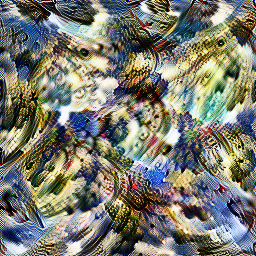

7756


100%|██████████| 2560/2560 [01:49<00:00, 23.40it/s]



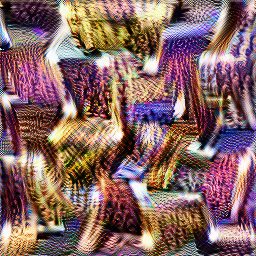

7270


100%|██████████| 2560/2560 [01:49<00:00, 23.39it/s]



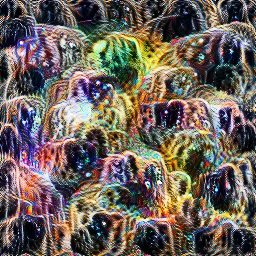

6852


100%|██████████| 2560/2560 [01:49<00:00, 23.43it/s]



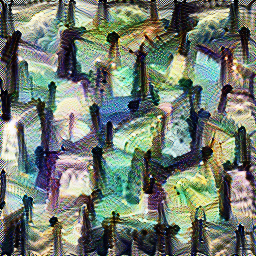

6743


100%|██████████| 2560/2560 [01:48<00:00, 23.67it/s]



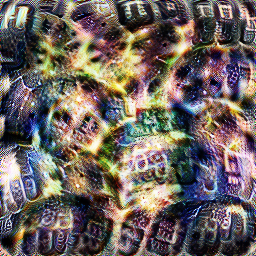

6560


100%|██████████| 2560/2560 [01:48<00:00, 23.63it/s]



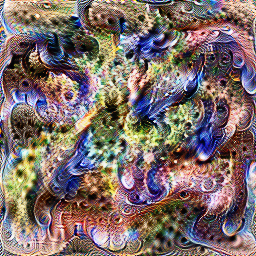

6475


100%|██████████| 2560/2560 [01:48<00:00, 23.60it/s]



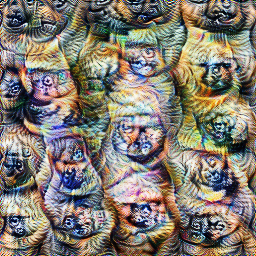

2238


100%|██████████| 2560/2560 [01:48<00:00, 23.56it/s]



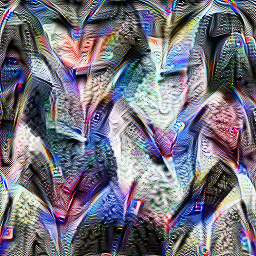

345


In [ ]:
import torch
"""***** VISUALIZE FEATURES *****"""
from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo import inceptionv1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model1 = inceptionv1(pretrained=True)
_ = model1.to(device).eval()
lis=[3341,
3221,
3185,
3021,
2489,
2475,
2417,
2325,
2293,
2278,
2156,
2091,
1891,
1755,
1421,
1415,
1210,
851,
736,
602,
543,
371,
224,
118

]
#for i in range(1792):



# animal orientation7764, 5099, 4829, 1543,8109,8052,7845,7807,7794,7620,7488,7209,7161,6518,6418,6141,6054,5921,5656,7994,7379,6809
#3290,3183,3167,2966,2929,2902,2523,2046,1882,1630,1495,1466,1297,1285,1279,1231,1216,1083,999,386,368,206,27,7516,7279,6690,6641,4988,4583,3553,3359,1485,526,119
#
for i in dic:

  obj = objectives.direction("mixed4b",model.W_dec.weight[:,i[0]].to(device))
  param_f = lambda: param.image(256, fft=True, decorrelate=True)# Add .to(device) here

  transforms1=[transform.pad(24),
                              transform.jitter(8),
                              transform.random_scale([1, 0.975, 1.025, 0.95, 1.05]),
                              transform.random_rotate(list(range(-5,5))),
                              transform.jitter(8),
                                          transform.pad(-24)]
                              #transform.pad(-16)]
  transforms2=[
              transform.pad(12, mode="constant", constant_value=0.5),
              transform.jitter(10),
              transform.random_scale([1 + (i - 5) / 50.0 for i in range(11)]),
              transform.random_rotate(list(range(-10, 11)) + 5 * [0]),
              transform.jitter(6),
              ]
              #655,#695 #724 #1090 1284 1368 1446 1480 1504 1711 1725
                  # We initialize an optimizer with lower learning rate for CPPN
  cppn_opt = lambda params: torch.optim.Adam(params, 5e-2)
  _ = render.render_vis(model1, obj,optimizer=cppn_opt,param_f=param_f ,transforms=transforms2,show_inline=True, thresholds=(2560,))
print(i[0])
#print(i)

In [ ]:
import torch
dic=[]
for i in range(8128):
    if torch.max(model.W_dec.weight[:,i],dim=0)[1]==409:
       dic.append((i,torch.max(model.W_dec.weight[:,i],dim=0)[0]))

dic.sort(key=lambda x: x[0], reverse=True)

In [ ]:
print(torch.topk(model.W_dec.weight[:,87],dim=0,k=5)[1])

for i in dic:

  print(i[0])

tensor([214,   5, 216, 500,  54], device='cuda:0')
5574
1607
1192
1081


In [ ]:
"""Create Graphs from paper"""




dic=[5658,
5635,
5626,
5563,
5356,
5228,
5014,
4966,
4765,
4709,
4321,
4215,
4131,
4099,
4013,
3931,
3916,
3886,
3833,
3783,
3763,
3761,
3745,
3608,
3591,
3414,
3241,
3129,
3068,
3066,
3046,
3002,
2912,
2635,
2558,
2406,
2279,
2137,
2124,
2092,
8078,
7989,
7952,
7626,
7268,
7036,
6943,
6874,
6815,
6808,
6655,
6590,
6456,
6384,
5846,
5826,
5754,
4899,
4832,
4423,
3912,
3757,
3586,
3540,
3391,
3234,
2950,
2908,
2890,
2643,
2641,
2447,
2435,
2393,
2325,
1919,
1828,
1707,
1680,
1475,
1457,
874,
832,
820,
591,
376,
259,
251,
7965,
7488,
7353,
7143,
5168,
3785,
3508,
3327,
3218,
3106,
2797,
2741,
1780,
1690,
1271,
817,
795]
color_detect_features={}
from torch import linalg as LA
lis={}
for i in range(8128):
   vec=model.W_dec.weight[:,i]
   vec_1=vec[384:448]
   vec_new=vec_1.clamp(min=0.0)
   vec_full=vec.clamp(min=0.0)
   print(vec_new.norm(dim=0)/vec_full.norm(dim=0))
   if i in dic and vec_new.norm(dim=0)/vec_full.norm(dim=0):
    color_detect_features[i]=(vec_new.norm(dim=0)/vec_full.norm(dim=0)).cpu().item()


   lis[i]=(vec_new.norm(dim=0)/vec_full.norm(dim=0)).cpu().item()


print(color_detect_features)




Streaming output truncated to the last 5000 lines.
tensor(0.9891, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6172, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2025, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5406, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1898, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4571, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2774, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2774, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8275, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2570, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1672, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3221, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6266, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7047, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3586, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3432, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9496, device='cuda:0', grad_fn=<DivBackward0

In [ ]:
import itertools



sorted_dict = dict(sorted(lis.items(), key=lambda item: item[1]))



new_dict = {i: v for i, (k, v) in enumerate(sorted_dict.items())}

print(new_dict)

features_dict={}
for i in range(8128):
  if new_dict[i] in color_detect_features.values():
    features_dict[i]=new_dict[i]
print(features_dict)










{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0011133315274491906, 4: 0.0014272377593442798, 5: 0.0014893156476318836, 6: 0.0023127621971070766, 7: 0.002891668351367116, 8: 0.004117109812796116, 9: 0.004271363839507103, 10: 0.005360239651054144, 11: 0.005575956776738167, 12: 0.006595310289412737, 13: 0.007204987574368715, 14: 0.00902840681374073, 15: 0.00917737651616335, 16: 0.009893658570945263, 17: 0.011830296367406845, 18: 0.012130985967814922, 19: 0.013098069466650486, 20: 0.01334897056221962, 21: 0.016158124431967735, 22: 0.01715296506881714, 23: 0.017705487087368965, 24: 0.01776869036257267, 25: 0.017809636890888214, 26: 0.019328931346535683, 27: 0.020956944674253464, 28: 0.02292608842253685, 29: 0.02414068579673767, 30: 0.02487633191049099, 31: 0.02499392069876194, 32: 0.02585332654416561, 33: 0.027161747217178345, 34: 0.028701046481728554, 35: 0.029996436089277267, 36: 0.030513552948832512, 37: 0.030622242018580437, 38: 0.03273867070674896, 39: 0.03407438471913338, 40: 0.03423789143562317, 41:

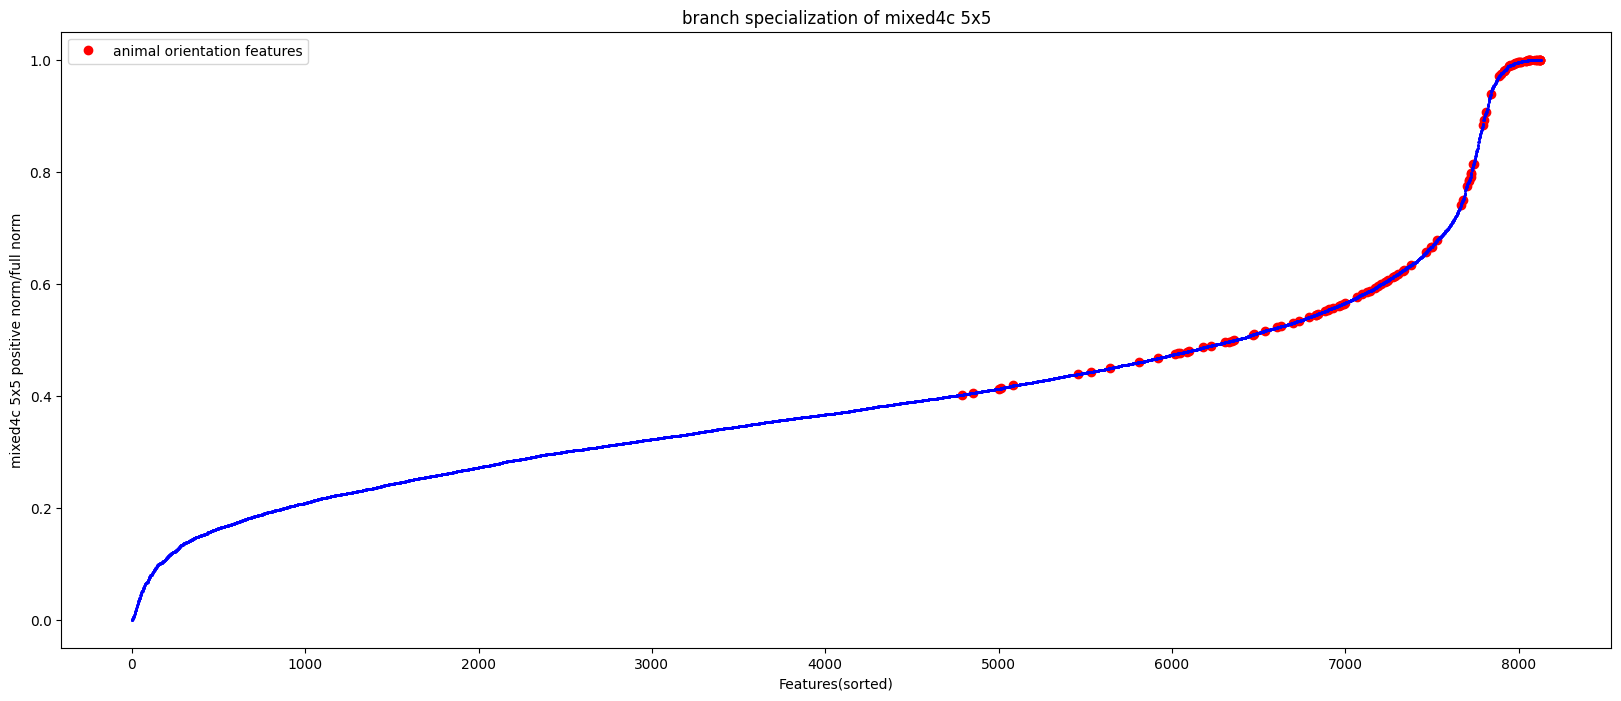

In [ ]:
import matplotlib.pyplot as plt

# Data from your dictionaries
x = list(new_dict.keys())
y = list(new_dict.values())

x_1 = list(features_dict.keys())
y_1 = list(features_dict.values())

# Create the scatter plot on the same figure
plt.figure(figsize=(20, 8))
plt.plot(x_1, y_1, marker='o', linestyle='none', color='red', label='animal orientation features')
plt.plot(x, y, marker='o', linestyle='none', color='blue', markersize=1, )

plt.xlabel('Features(sorted)')
plt.ylabel('mixed4c 5x5 positive norm/full norm')
plt.title('branch specialization of mixed4c 5x5')
plt.legend()  # Add legend to differentiate the datasets
plt.savefig('mixed4c_5x5.png', dpi=300)
plt.show()
# Create the scatter plot






In [ ]:
for i in dic:
  print(i[0])

6055
4602
3604
1649


In [ ]:
import torch
from torch.utils.data import DataLoader

# Initialize model and dataset
from google.colab import drive

dataloader = DataLoader(dataset, batch_size=400, num_workers=4, pin_memory=True)

# Hook to capture activations
activation_cache = {}
def get_activation(name):
    def hook(model, input, output):
        activation_cache[name] = output.detach()  # Shape: [batch, C, H, W]
    return hook
target_layer = model1.mixed4a_3x3 # Replace with your InceptionV1 layer
target_layer.register_forward_hook(get_activation('mixed4a_3x3'))

activation_list = []

num_samples = 1 # Samples per image
epsilon = 1e-8

with torch.no_grad():
    for batch_idx,batch in enumerate(dataloader):
        images = batch['image'].to(device, non_blocking=True)

        # Forward pass (batched)
        _ = model1(images)
        activations = activation_cache['mixed4a_3x3']  # Shape: [B, C, H, W]


        B, C, H, W = activations.shape
        magnitudes = torch.norm(activations, p=2, dim=1)  # [B, H, W]
        flattened_mags = magnitudes.view(B, -1)  # [B, H*W]


        probs = (flattened_mags + epsilon) / (flattened_mags.sum(dim=1, keepdim=True) + epsilon * H*W)


        indices = torch.multinomial(probs, num_samples, replacement=True)  # [B, num_samples]


        # Reshape activations to [B, C, H*W] and gather vectors
        activations_flat = activations.view(B, C, -1)
        sampled_vectors = activations_flat.gather(
            2,
            indices.unsqueeze(1).expand(-1, C, -1)  # [B, C, num_samples]
        ).permute(0, 2, 1).reshape(-1, C)  # [B*num_samples, C]
         # [B]
        loss,reconstruction,latent=model(sampled_vectors.to(device),32)
        activations = latent[:, 0]

        print(activations.shape)
        first_slot_vals = latent[:, :num_samples]
        print(first_slot_vals.shape)
        max_vals, _ = first_slot_vals.max(dim=1)
        start_idx = batch_idx * dataloader.batch_size
        for i, act_val in enumerate(activations):
            img_path = images[i].cpu()
            activation_list.append((act_val.item(), img_path))
        activation_cache.clear()
top_n = 10
print(f"Top {top_n} images that maximally activate hidden unit {TARGET_UNIT}:")
for rank, (score, path) in enumerate(activation_list[:top_n], start=1):
    print(f"{rank}. {path} -- activation score: {score:.4f}")


fig, axes = plt.subplots(1, top_n, figsize=(20, 4))
for i, (score, path) in enumerate(activation_list[:top_n]):
    img = Image.open(path)
    axes[i].imshow(img)
    axes[i].set_title(f"Score: {score:.2f}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()




/usr/local/lib/python3.11/dist-packages/datasets/formatting/torch_formatter.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/usr/local/lib/python3.11/dist-packages/datasets/formatting/torch_formatter.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
/usr/local/lib/python3.11/dist-packages/datasets/formatting/torch_formatter.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  retur

KeyboardInterrupt: 

In [ ]:
import torch
from torch.utils.data import DataLoader
"""Manual identification of features for a particular neuron"""


dataloader = DataLoader(dataset, batch_size=1300, num_workers=4, pin_memory=True)


activation_cache = {}
def get_activation(name):
    def hook(model, input, output):
        activation_cache[name] = output.detach()  # Shape: [batch, C, H, W]
    return hook
target_layer = model1.mixed4a_3x3 # Replace with your InceptionV1 layer
target_layer.register_forward_hook(get_activation('mixed4a_3x3'))

activation_list = []

num_samples = 1 # Samples per image
epsilon = 1e-8
TARGET_UNIT=216
with torch.no_grad():
    for batch_idx,batch in enumerate(dataloader):
        images = batch['image'].to(device, non_blocking=True)  # Batch on GPU


        _ = model1(images)
        activations = activation_cache['mixed4a_3x3']  # Shape: [B, C, H, W]


        B, C, H, W = activations.shape
        magnitudes = torch.norm(activations, p=2, dim=1)  # [B, H, W]
        flattened_mags = magnitudes.view(B, -1)  # [B, H*W]


        probs = (flattened_mags + epsilon) / (flattened_mags.sum(dim=1, keepdim=True) + epsilon * H*W)


        indices = torch.multinomial(probs, num_samples, replacement=True)  # [B, num_samples]
        print(indices.shape)
        rows = indices // W
        cols = indices % W


        downsample_factor = 16
        # Compute the approximate center pixel coordinates in the input image:
        centers_y = rows.float() * downsample_factor + downsample_factor / 2
        centers_x = cols.float() * downsample_factor + downsample_factor / 2


        # Reshape activations to [B, C, H*W] and gather vectors
        activations_flat = activations.view(B, C, -1)
        sampled_vectors = activations_flat.gather(
            2,
            indices.unsqueeze(1).expand(-1, C, -1)  # [B, C, num_samples]
        ).permute(0, 2, 1).reshape(-1, C)  # [B*num_samples, C]
         # [B]
        loss,reconstruction,latent=model(sampled_vectors.to(device),32)
        activations = latent[:, TARGET_UNIT]

        print(activations.shape)
        first_slot_vals = latent[:, :num_samples]
        print(first_slot_vals.shape)
        max_vals, _ = first_slot_vals.max(dim=1)

        start_idx = batch_idx * dataloader.batch_size
        print(start_idx)
        for i, act_val in enumerate(activations):

            img_path = start_idx+i

            activation_list.append((act_val.item(), img_path,centers_x[i],centers_y[i]))
        activation_cache.clear()
        #if start_idx>=1000000:

top_n = 10
print(f"Top {top_n} images that maximally activate hidden unit {TARGET_UNIT}:")
for rank, (score, path) in enumerate(activation_list[:top_n], start=1):
    print(f"{rank}. {path} -- activation score: {score:.4f}")


fig, axes = plt.subplots(1, top_n, figsize=(20, 4))
for i, (score, path) in enumerate(activation_list[:top_n]):
    img = Image.open(path)
    axes[i].imshow(img)
    axes[i].set_title(f"Score: {score:.2f}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

NameError: name 'dataset' is not defined

In [ ]:
import torch
from torchvision.transforms import ToPILImage
"""activating examples for a feature"""
activation_list.sort(key=lambda x: x[0], reverse=True)
print(f"Top {top_n} images that maximally activate hidden unit {TARGET_UNIT}:")
for rank, (score, path,centers_x,centers_y) in enumerate(activation_list[:top_n], start=1):
    print(f"{rank}. {path} -- activation score: {score:.4f}")

for i, (score, path,centers_x,centers_y) in enumerate(activation_list[:top_n]):
    rf_size = 100  # receptive field (window) size in pixels
    half_window = rf_size // 2
    center_y = int(centers_y.item())
    center_x = int(centers_x.item())
    from PIL import Image

# Assume `img` is your PIL Image
# Compute the crop boundaries

    to_pil = ToPILImage()
    pil_image = to_pil(dataset[path]['image'])
    left   = max(center_x - half_window, 0)
    upper  = max(center_y - half_window, 0)
    right  = min(center_x + half_window, pil_image.width)
    lower  = min(center_y + half_window, pil_image.height)

    # Optionally, if the crop is smaller than desired near the borders, you might want to adjust.
    crop_box = (left, upper, right, lower)
    pil_image.show()
    cropped_region = pil_image.crop(crop_box)
    cropped_region.show()

In [ ]:
dict=[]
for i in range(3264):
    if torch.max(model.W_dec.weight[:,i],dim=0)[1]==25:
       dict.append((i,torch.max(model.W_dec.weight[:,i],dim=0)[0]))
